# Import

In [2]:
import os
from dotenv import load_dotenv
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import category_encoders as ce

import torch
from torch.utils.data import Dataset


load_dotenv()
sklearn.set_config(transform_output="pandas")

# Config

In [3]:
INPUT_DATA_PATH = os.getenv("INPUT_DATA_PATH")
OUTPUT_DATA_PATH = os.getenv("OUTPUT_DATA_PATH")

# Classes and functions

# Load data

In [4]:
user_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/users.tsv")
history_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/history.tsv")
validate_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate.tsv")

validate_answers_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate_answers.tsv")

In [5]:
user_ds = pd.read_csv(user_ds_path, sep="\t")
history_ds = pd.read_csv(history_ds_path, sep="\t")
validate_ds = pd.read_csv(validate_ds_path, sep="\t")

validate_answers_ds = pd.read_csv(validate_answers_ds_path, sep="\t")

# Explore data

## Step 1 - first connection

___
**users.tsv:**
- все пользователи уникальные,
- 30 пользователей без пола, примерно 50/50,
- 2180 пропущено возрастов, есть люди страше 90 лет,
- 84790 пропущено городов, город с id=3 концентрирует в себе пользователей.

**history.tsv:**
- два выброса по cpm,
- есть периодичность по времени,
- все просмотры сконцентрированы на 4 площадках,
- два пользователя смотрят очень много объявлений (мб выбросы и стоит обрезать).

**validate.tsv:**
- в среднем рекламу размещают на ~5 дней, 75% перцентиль покрывает 7 дней,
- максимум используется 6 площадок, в основном 3-4.

### validate.tsv

Какой в среднем период размещения рекламы

In [ ]:
(validate_ds["hour_end"] - validate_ds["hour_start"]).describe()

count    1008.000000
mean      101.178571
std       126.397082
min         2.000000
25%         8.000000
50%        36.500000
75%       169.750000
max       503.000000
dtype: float64

In [13]:
169/24

7.041666666666667

<BarContainer object of 24 artists>

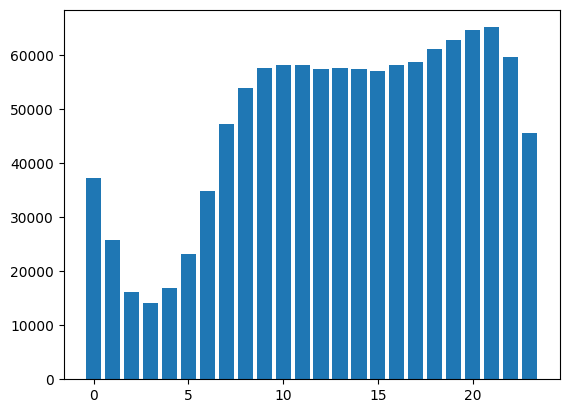

In [150]:
v, c = np.unique(ext_history_ds["hour"], return_counts=True)
plt.bar(v, c)

<BarContainer object of 7 artists>

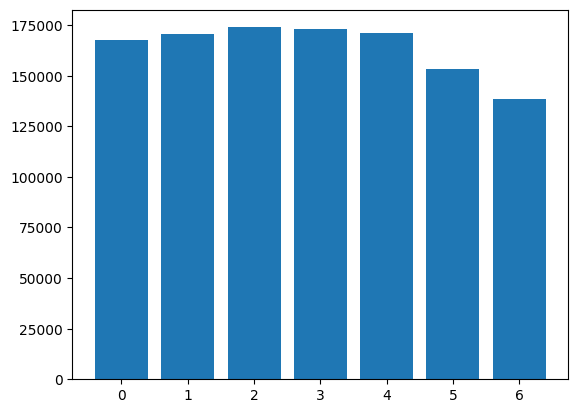

In [151]:
v, c = np.unique(ext_history_ds["weekday"], return_counts=True)
plt.bar(v, c)

## Step 2 - feature importance

# Clean and prepare data

## Step 1 - raw data

### user.tsv

Заполняем пропуски единицей, приводим к бинарному виду для sex.

In [ ]:
user_ds["sex"] = user_ds["sex"].replace(0, 1)
user_ds["sex"] = user_ds["sex"] - 1
user_ds.head()

,user_id,sex,age,city_id
0,0,1,19,0
1,1,0,0,1
2,2,1,24,2
3,3,0,20,3
4,4,1,29,4


Для того, чтобы заполнить пропуски в age воспользуемся следующим:
1) добавим новые признаки пользователям,
2) масштабируем признаки,
3) посчитаем для каждого пропуска ближайшее значение.

In [ ]:
# Создадим дополнительную таблицу для лучшего понимания распределения
add_user_ds = user_ds.copy()

add_data = {
    "publishers": [],
    "publisher_quantity": [],
    "hours": [],
    "weekdays": [],
    "views": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    user_id = row["user_id"]

    add_data["publishers"].append(np.unique(history_ds[history_ds["user_id"] == user_id]["publisher"]))
    add_data["publisher_quantity"].append(len(add_data["publishers"][i]))
    add_data["hours"].append(list(history_ds[history_ds["user_id"] == user_id]["hour"]))
    add_data["weekdays"].append(list(history_ds[history_ds["user_id"] == user_id]["weekday"]))
    add_data["views"].append(len(add_data["hours"][i]))

add_user_ds = add_user_ds.assign(**add_data)

100%|██████████| 27769/27769 [00:58<00:00, 473.02it/s]


In [ ]:
# Добавим категориальные признаки top_hour: ["22-7", "8-15", "16-21"], top_hour_ratio: float и is_weekend: float
new_data = {
    "top_time_interval": [],
    "top_time_interval_ratio": [],
    "is_workday": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    if row["views"] == 0:
        new_data["top_time_interval"].append(None)
        new_data["top_time_interval_ratio"].append(None)
        new_data["is_workday"].append(None)
        continue

    hours, counts = np.unique(row["hours"], return_counts=True)
    intervals = {
        "22-7": (hours <= 7) | (hours >= 22),
        "8-15": (hours >= 8) & (hours <= 15),
        "16-21": (hours >= 16) & (hours <= 21),
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    top_time_interval = max(interval_counts, key=interval_counts.get)
    top_time_interval_ratio = interval_counts[top_time_interval]/np.sum(list(interval_counts.values()))

    weekdays, counts = np.unique(row["weekdays"], return_counts=True)
    intervals = {
        "0-4": (weekdays <= 4),
        "5-6": (weekdays >= 5)
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    is_workday = interval_counts["0-4"]/np.sum(list(interval_counts.values()))
    
    new_data["top_time_interval"].append(top_time_interval)
    new_data["top_time_interval_ratio"].append(top_time_interval_ratio)
    new_data["is_workday"].append(is_workday)

add_user_ds = add_user_ds.assign(**new_data)

100%|██████████| 27769/27769 [00:03<00:00, 8077.44it/s]


In [ ]:
# Добавим категориальные признаки
# Есть ли популярная площадка top_publisher_type: ["well_done", "medium", "rare"]
# Доля популярной площадки top_publisher_type_ratio: float
new_data = {
    "top_publisher": [],
    "top_publisher_ratio": []
}
for i, row in tqdm(add_user_ds.iterrows(), total=len(add_user_ds)):
    if row["publisher_quantity"] == 0:
        new_data["top_publisher"].append(None)
        new_data["top_publisher_ratio"].append(None)
        continue

    publishers, counts = np.unique(row["publishers"], return_counts=True)
    intervals = {
        "well_done": (publishers <= 2),
        "medium": (publishers == 3) | (publishers == 7),
        "rare": (publishers == 4) | (publishers == 5) | (publishers == 6) | (publishers >= 8),
    }
    interval_counts = {key: np.sum(counts[mask]) for key, mask in intervals.items()}

    top_publisher = max(interval_counts, key=interval_counts.get)
    top_publisher_ratio = interval_counts[top_publisher]/np.sum(list(interval_counts.values()))

    new_data["top_publisher"].append(top_publisher)
    new_data["top_publisher_ratio"].append(top_publisher_ratio)

add_user_ds = add_user_ds.assign(**new_data)

100%|██████████| 27769/27769 [00:02<00:00, 11881.99it/s]


In [ ]:
с_add_user_ds = add_user_ds.copy()

In [ ]:
# Меняем категориальные признаки
encoder = ce.CountEncoder(cols=["city_id"])
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,8-15,0.500000,1.000000,well_done,1.0
1,1,0,0,16,1,82,8-15,0.585366,0.597561,well_done,1.0
2,2,1,24,1,0,0,None,NaN,NaN,None,NaN
3,3,0,20,1985,2,8,8-15,0.500000,0.750000,well_done,0.5
4,4,1,29,66,2,132,8-15,0.560606,0.848485,well_done,0.5


In [ ]:
encoder = ce.OneHotEncoder(cols=["top_time_interval"], use_cat_names=True, handle_missing="return_nan")
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,well_done,1.0
1,1,0,0,16,1,82,1.0,0.0,0.0,0.585366,0.597561,well_done,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,None,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,well_done,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,well_done,0.5


In [ ]:
mapping = [{'col': 'top_publisher', 'mapping': {"well_done": 3, "medium": 2, "rare": 1}}]
encoder = ce.OrdinalEncoder(mapping=mapping, cols=["top_publisher"], drop_invariant=True, handle_missing="return_nan")
с_add_user_ds = encoder.fit_transform(с_add_user_ds)
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1.0,0.0,0.0,0.500000,1.000000,3.0,1.0
1,1,0,0,16,1,82,1.0,0.0,0.0,0.585366,0.597561,3.0,1.0
2,2,1,24,1,0,0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN
3,3,0,20,1985,2,8,1.0,0.0,0.0,0.500000,0.750000,3.0,0.5
4,4,1,29,66,2,132,1.0,0.0,0.0,0.560606,0.848485,3.0,0.5


In [ ]:
# Переводим в int
с_add_user_ds = с_add_user_ds.replace({'top_publisher': -1}, np.nan)
с_add_user_ds = с_add_user_ds.astype({"top_time_interval_8-15": "Int64", "top_time_interval_16-21": "Int64", "top_time_interval_22-7": "Int64", "top_publisher": "Int64"})
с_add_user_ds.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,0,16,1,82,1,0,0,0.585366,0.597561,3,1.0
2,2,1,24,1,0,0,<NA>,<NA>,<NA>,NaN,NaN,<NA>,NaN
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5


In [ ]:
# Убираем выбросы: кто старше 90 тому присваиваем mean
mask = ((с_add_user_ds["age"] != 0) & (с_add_user_ds["age"] < 90))
mean_age = np.mean(с_add_user_ds.loc[mask, "age"]).astype(np.int64)

mask = с_add_user_ds["age"] >= 90
с_add_user_ds.loc[mask, "age"] = mean_age

In [ ]:
# Возьмем юзеров без пропущенных значений
c_add_user_ds_subset = с_add_user_ds[с_add_user_ds["views"] != 0]
c_add_user_ds_subset.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,0,16,1,82,1,0,0,0.585366,0.597561,3,1.0
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5
5,5,1,22,20,1,9,1,0,0,0.888889,0.666667,2,1.0


In [ ]:
# Присвоим None к возрасту и заполним их
c_add_user_ds_subset = c_add_user_ds_subset.replace({"age": 0}, np.nan)

imputer = KNNImputer(n_neighbors=5, weights="uniform")
c_add_user_ds_subset["age"] = imputer.fit_transform(c_add_user_ds_subset.drop(columns=["user_id"]))["age"].astype(np.int64)
c_add_user_ds_subset.head()

,user_id,sex,age,city_id,publisher_quantity,views,top_time_interval_8-15,top_time_interval_16-21,top_time_interval_22-7,top_time_interval_ratio,is_workday,top_publisher,top_publisher_ratio
0,0,1,19,8479,1,2,1,0,0,0.500000,1.000000,3,1.0
1,1,0,30,16,1,82,1,0,0,0.585366,0.597561,3,1.0
3,3,0,20,1985,2,8,1,0,0,0.500000,0.750000,3,0.5
4,4,1,29,66,2,132,1,0,0,0.560606,0.848485,3,0.5
5,5,1,22,20,1,9,1,0,0,0.888889,0.666667,2,1.0


In [ ]:
# Вносим в наш датасет найденные значения
mask = с_add_user_ds['user_id'].isin(c_add_user_ds_subset['user_id'])
с_add_user_ds.loc[mask, "age"] = c_add_user_ds_subset["age"]

# Feature engineering

In [27]:
ext_user_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_users.csv"))
ext_user_ds = ext_user_ds[["user_id", "sex", "age", "city_id"]]
ext_user_ds.head()

,user_id,sex,age,city_id
0,0,1,19,8479
1,1,0,30,16
2,2,1,24,1
3,3,0,20,1985
4,4,1,29,66


In [29]:
ext_history_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_history.csv"))
ext_history_ds.head()

,hour_old,cpm,publisher,user_id,weekday,hour
0,10,30.00,1,15661,0,10
1,8,41.26,1,8444,0,8
2,7,360.00,1,15821,0,7
3,18,370.00,1,21530,0,18
4,8,195.00,2,22148,0,8


In [70]:
ext_validate_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate.csv"))
ext_validate_ds["publishers"] = ext_validate_ds["publishers"].apply(ast.literal_eval)
ext_validate_ds["user_ids"] = ext_validate_ds["user_ids"].apply(ast.literal_eval)
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4


In [31]:
ext_validate_answers_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_answers.csv"))
ext_validate_answers_ds.head()

,at_least_one,at_least_two,at_least_three
0,82,29,14
1,18,0,0
2,78,12,0
3,101,57,32
4,585,411,335


Добавим для каждого объекта из validate.tsv новые признаки.

1) Среднее количество используемых в рекламе площадок среди пользователей за месяц в отношении к данным площадкам:

In [77]:
new_data = {
    "used_publishers_ration": []
}
for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    publishers = row["publishers"]
    user_ids = row["user_ids"]
    start = row["hour_start_old"] - 31*24
    end = row["hour_start_old"]

    # Берем пользователей рекламы, площадки на которых размещаем и исторические данные за месяц
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["publisher"].isin(publishers)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_publishers = ext_history_ds.loc[mask, ["publisher", "user_id"]]
    # Для каждого пользователя считаем сколько подходящих групп он использовал и от этого берем среднее
    used_publishers_mean = np.mean(users_publishers.groupby("user_id")["publisher"].apply(lambda publishers: len(np.unique(publishers))))
    # Считаем отношение
    used_publishers_ration = used_publishers_mean/len(publishers)

    new_data["used_publishers_ration"].append(used_publishers_ration)

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [00:39<00:00, 25.28it/s]


In [91]:
ext_validate_ds["used_publishers_ration"].isna().sum()

np.int64(0)

In [81]:
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity,used_publishers_ration
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2,0.500000
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2,0.503846
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6,0.185101
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2,0.502347
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4,0.292857


2) Пик активности у пользователей за неделю, месяц по времени, дню недели:

In [87]:
new_data = {
    "top_time_month": [],
    "top_time_week": [],
    "top_weekday_month": [],
    "top_weekday_week": []
}
for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    user_ids = row["user_ids"]
    end = row["hour_start_old"]
    # Время-месяц
    start = row["hour_start_old"] - 31*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, "hour"]
    users_weekdays = ext_history_ds.loc[mask, "weekday"]

    top_time_month = stats.mode(users_hours)[0]
    top_weekday_month = stats.mode(users_weekdays)[0]
    # Время-неделя
    start = row["hour_start_old"] - 7*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, "hour"]
    users_weekdays = ext_history_ds.loc[mask, "weekday"]

    top_time_week = stats.mode(users_hours)[0]
    top_weekday_week = stats.mode(users_weekdays)[0]

    new_data["top_time_month"].append(top_time_month)
    new_data["top_time_week"].append(top_time_week)
    new_data["top_weekday_month"].append(top_weekday_month)
    new_data["top_weekday_week"].append(top_weekday_week)

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [00:29<00:00, 33.72it/s]


In [90]:
ext_validate_ds[["top_time_month", "top_time_week", "top_weekday_month", "top_weekday_week"]].isna().sum()

top_time_month       0
top_time_week        0
top_weekday_month    0
top_weekday_week     0
dtype: int64

In [ ]:
round(ext_validate_ds[["top_time_month", "top_time_week", "top_weekday_month", "top_weekday_week"]].describe(), 2)

,top_time_month,top_time_week,top_weekday_month,top_weekday_week
count,1008.00,1008.00,1008.00,1008.00
mean,19.04,18.28,2.26,2.18
std,3.47,3.82,1.63,1.51
min,0.00,0.00,0.00,0.00
25%,19.00,17.00,1.00,1.00
50%,20.00,20.00,2.00,2.00
75%,21.00,21.00,4.00,3.00
max,23.00,23.00,6.00,6.00


3) Среднее время сессии у пользователей за месяц, неделю
4) Кол-во сессий у пользователей за месяц, неделю
5) Средняя цена сессий за месяц, неделю
6) Среднее кол-во просмотров у сессий за месяц, неделю

In [137]:
new_data = {
    "session_duration_month_mean": [],
    "session_duration_week_mean": [],

    "session_quantity_month": [],
    "session_quantity_week": [],

    "session_cpm_month_mean": [],
    "session_cpm_week_mean": [],

    "views_month_mean": [],
    "views_week_mean": []
}
for _, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    user_ids = row["user_ids"]
    end = row["hour_start_old"]
    # Месяц
    start = row["hour_start_old"] - 31*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, ["user_id", "hour_old", "cpm"]].sort_values("hour_old")
    # Группируем по пользователям и считаем сколько времени длилась сессия
    users_sessions = []
    users_cpms = []
    for _, h_row in users_hours.groupby("user_id"):
        hours = list(h_row["hour_old"])
        cpms = list(h_row["cpm"])

        user_sessions = [hours[0]]
        user_cpms = [cpms[0]]
        for i, hour in enumerate(hours[1:], 1):
            if hour - user_sessions[-1] <= 6:
                user_sessions.append(hour)
                user_cpms.append(cpms[i])
                continue

            users_sessions.append(user_sessions)
            users_cpms.append(user_cpms)
            user_sessions = [hour]
            user_cpms = [cpms[i]]
        
        users_sessions.append(user_sessions)
        users_cpms.append(user_cpms)

    session_duration_month_mean = round(np.mean([np.max(user_sessions) - np.min(user_sessions) + 1 for user_sessions in users_sessions]))
    session_quantity_month = len(users_sessions)
    session_cpm_month_mean = np.mean([np.mean(user_cpms) for user_cpms in users_cpms])
    views_month_mean = len(users_hours)
    # Неделя
    start = row["hour_start_old"] - 7*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, ["user_id", "hour_old", "cpm"]].sort_values("hour_old")
    # Группируем по пользователям и считаем сколько времени длилась сессия
    users_sessions = []
    users_cpms = []
    for _, h_row in users_hours.groupby("user_id"):
        hours = list(h_row["hour_old"])
        cpms = list(h_row["cpm"])

        user_sessions = [hours[0]]
        user_cpms = [cpms[0]]
        for i, hour in enumerate(hours[1:], 1):
            if hour - user_sessions[-1] <= 6:
                user_sessions.append(hour)
                user_cpms.append(cpms[i])
                continue

            users_sessions.append(user_sessions)
            users_cpms.append(user_cpms)
            user_sessions = [hour]
            user_cpms = [cpms[i]]
        
        users_sessions.append(user_sessions)
        users_cpms.append(user_cpms)

    session_duration_week_mean = round(np.mean([np.max(user_sessions) - np.min(user_sessions) + 1 for user_sessions in users_sessions]))
    session_quantity_week = len(users_sessions)
    session_cpm_week_mean = np.mean([np.mean(user_cpms) for user_cpms in users_cpms])
    views_week_mean = len(users_hours)

    new_data["session_duration_month_mean"].append(session_duration_month_mean)
    new_data["session_duration_week_mean"].append(session_duration_week_mean)

    new_data["session_quantity_month"].append(session_quantity_month)
    new_data["session_quantity_week"].append(session_quantity_week)

    new_data["session_cpm_month_mean"].append(session_cpm_month_mean)
    new_data["session_cpm_week_mean"].append(session_cpm_week_mean)

    new_data["views_month_mean"].append(views_month_mean)
    new_data["views_week_mean"].append(views_week_mean)

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [05:06<00:00,  3.29it/s]


In [146]:
round(ext_validate_ds[['session_duration_month_mean', 'session_duration_week_mean',
       'session_quantity_month', 'session_quantity_week',
       'session_cpm_month_mean', 'session_cpm_week_mean', 'views_month_mean',
       'views_week_mean']].describe(), 2)

,session_duration_month_mean,session_duration_week_mean,session_quantity_month,session_quantity_week,session_cpm_month_mean,session_cpm_week_mean,views_month_mean,views_week_mean
count,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00
mean,2.15,2.14,10912.88,2510.06,242.14,251.63,24276.27,5601.70
std,0.57,0.56,10173.41,2355.25,153.55,164.27,28332.79,6563.43
min,1.00,1.00,129.00,28.00,58.50,54.61,133.00,29.00
25%,2.00,2.00,4356.75,993.75,185.73,188.39,8864.00,2023.50
50%,2.00,2.00,8726.00,2008.00,210.27,216.24,17867.00,4099.00
75%,2.00,2.00,14222.50,3249.75,232.61,249.64,30527.50,7013.00
max,4.00,4.00,81393.00,19038.00,1102.84,1301.24,251260.00,58649.00


In [147]:
ext_validate_ds.columns

Index(['cpm', 'hour_start_old', 'hour_end', 'publishers', 'audience_size',
       'user_ids', 'weekday_start', 'duration', 'hour_start',
       'publisher_quantity', 'used_publishers_ration', 'top_time_month',
       'top_time_week', 'top_weekday_month', 'top_weekday_week',
       'session_duration_month_mean', 'session_duration_week_mean',
       'session_quantity_month', 'session_quantity_week',
       'session_cpm_month_mean', 'session_cpm_week_mean', 'views_month_mean',
       'views_week_mean'],
      dtype='object')

In [148]:
ext_validate_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_2.csv"), index=False)